In [14]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'
import sys
sys.path.append('/home/chuikova/chuikova2/lib/python2.7/site-packages/')
import torch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
import imageio
import cv2

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [3]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [4]:
torch.cuda.set_device(0)

In [5]:
# pre and post processing for images
img_size = 270 # to change
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [6]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load('Models/vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [8]:
name_left = 'tentacle_l.jpg'
name_right = 'tentacle_r.jpg'

In [9]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir, image_dir]
img_names = ['cub2.jpg', name_right, name_left] 
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image_r, content_image_l = imgs_torch

In [10]:
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)

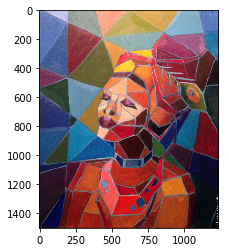

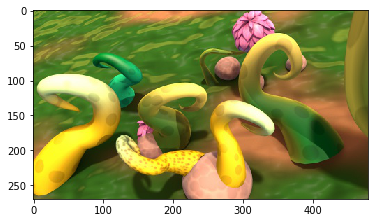

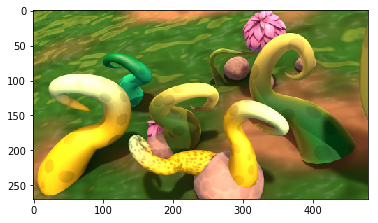

In [11]:
for img in imgs:
    imshow(img);show()

In [12]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets_r = [A.detach() for A in vgg(content_image_r, content_layers)]
content_targets_l = [A.detach() for A in vgg(content_image_l, content_layers)]
targets_r = style_targets + content_targets_r
targets_l = style_targets + content_targets_l

## Baseline: independent training

Iteration: 100, loss: 6738922.000000
Time: 0.1
Iteration: 200, loss: 3101737.000000
Time: 0.1
Iteration: 300, loss: 2203354.500000
Time: 0.1
Iteration: 400, loss: 1781834.750000
Time: 0.1
Iteration: 500, loss: 1590130.000000
Time: 0.1


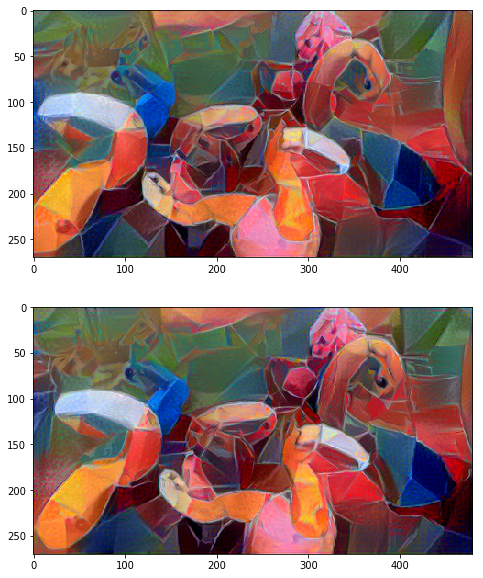

In [12]:
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter = 20)

max_iter = 500 
show_iter = 100 

n_iter=[0]
while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        loss += sum(layer_losses)
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [13]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_baseline134_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_baseline134_l.png')

## Disparity map with openCV

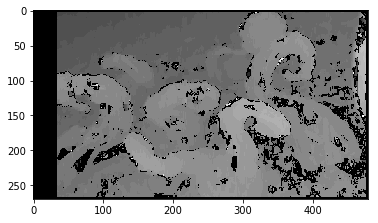

In [14]:
import cv2
import imageio
imgL = cv2.imread("Images/" + name_left, 0)
imgR = cv2.imread('Images/' + name_right, 0)
imgL = cv2.resize(imgL, (480, 270))
imgR = cv2.resize(imgR, (480, 270))
m, n = imgL.shape
stereo = cv2.StereoBM_create(numDisparities=32,blockSize=7)
disparity = stereo.compute(imgL,imgR)
#disparity = cv2.resize(disparity, (910,512))
m, n = disparity.shape
plt.imshow(disparity//16,'gray')
plt.show()

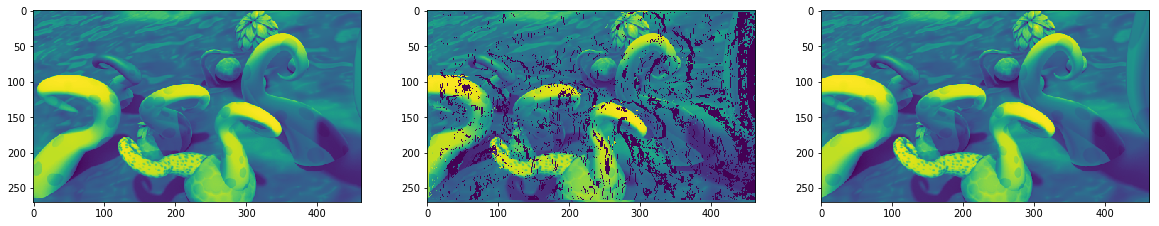

In [15]:
new_image = np.zeros_like(imgL)
m, n = disparity.shape

x = np.arange(0, m)
y = np.arange(0, n-1)
xx, yy = np.meshgrid(x, y)
i, j = np.array(xx, dtype = int), np.array(yy, dtype = int)
new_image[i, j-disparity[i, j]//16] = imgR[i, j]
plt.figure(figsize=(20, 18))
plt.subplot(131)
plt.imshow(imgL[:,17:])
plt.subplot(132)
plt.imshow(new_image[:,17:])
plt.subplot(133)
plt.imshow(imgR[:, 17:])

Iteration: 100, loss: 7362414.500000
Time: 0.0
('Disparity loss: ', 1.514775e+08)
Iteration: 200, loss: 3552816.500000
Time: 0.0
('Disparity loss: ', 80426080.0)
Iteration: 300, loss: 2481521.750000
Time: 0.0
('Disparity loss: ', 44365328.0)
Iteration: 400, loss: 1993664.250000
Time: 0.0
('Disparity loss: ', 27182646.0)
Iteration: 500, loss: 1754974.875000
Time: 0.0
('Disparity loss: ', 18378530.0)


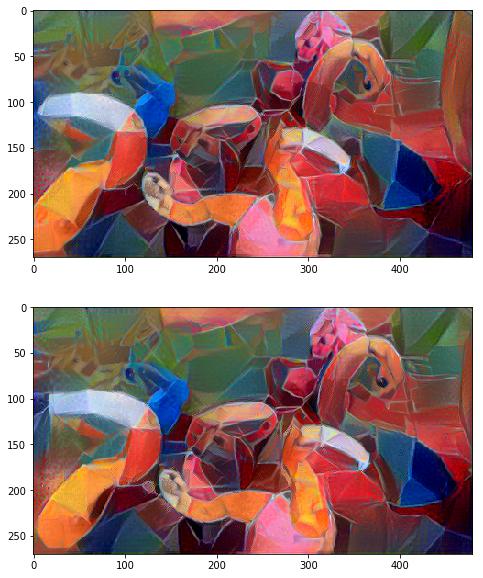

In [16]:
x = np.arange(0, m)
y = np.arange(0, n)
xx, yy = np.meshgrid(x, y)
i, j = np.array(xx, dtype = int), np.array(yy, dtype = int)

i = i.transpose(1,0)
j = j.transpose(1,0)
grid = np.expand_dims(np.stack([(j-disparity[i, j]//16),i], axis = 2),0)
grid_scaled = np.zeros_like(grid, dtype=np.float64)
grid_scaled[:,:,:,0] = (-1. + 2.*(grid[:,:,:,0] - grid[:,:,:,0].min())/(grid[:,:,:,0].max() - grid[:,:,:,0].min()))
grid_scaled[:,:,:,1] = (-1. + 2.*(grid[:,:,:,1] - grid[:,:,:,1].min())/(grid[:,:,:,1].max() - grid[:,:,:,1].min()))

max_iter = 500 
show_iter = 100 

opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter=1);

n_iter=[0]

while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        
        new_image = F.grid_sample(opt_img_r, Variable(torch.FloatTensor(grid_scaled)).cuda())
        loss += sum(layer_losses)
        
        
        loss_disp = (((opt_img_l[:,:,:,17:]-new_image[:,:,:,17:]))**2).sum() 
        loss += 0.005*loss_disp
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Time: %.1f' % ((time.time()- begin)/60))
            print('Disparity loss: ', loss_disp.data.cpu().numpy()[0])

        return loss
    
    optimizer.step(closure)
    
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [17]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_opencv_134_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_opencv_134_l.png')

## Based on ground-truth disparity

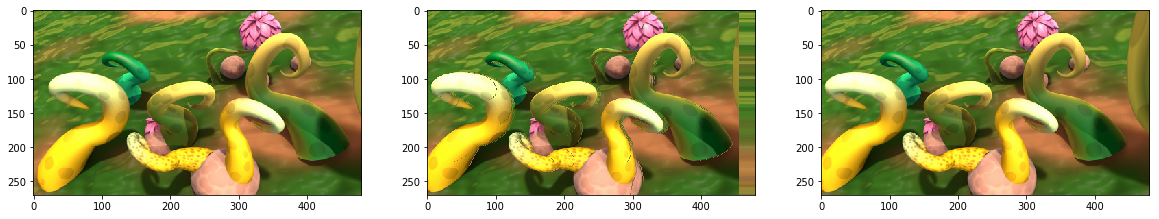

In [15]:
imgL = imageio.imread('Images/' + name_left)
imgR = imageio.imread('Images/' + name_right)
indices = np.load("tentacle_indices.npy")

indices_non_zero = indices*(indices>0)
indices_new = np.zeros_like(indices)
for r, row in enumerate(indices):
    for v, val in enumerate(row):
        if val >= 0:
            indices_new[r, val] = v
            
            
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)

m, n, _ = imgL.shape
x = np.arange(0, m)
y = np.arange(0, n)
xx, yy = np.meshgrid(x, y)
i= np.array(xx, dtype = int)

i = i.transpose(1,0)

#indices_new = indices*[indices>0]
grid = np.expand_dims(np.stack([indices_new,i], axis = 2),0)
grid_scaled = np.zeros_like(grid, dtype=np.float64)
grid_scaled[:,:,:,0] = (-1. + 2.*(grid[:,:,:,0] - grid[:,:,:,0].min())/(grid[:,:,:,0].max() - grid[:,:,:,0].min()))
grid_scaled[:,:,:,1] = (-1. + 2.*(grid[:,:,:,1] - grid[:,:,:,1].min())/(grid[:,:,:,1].max() - grid[:,:,:,1].min()))

newR = F.grid_sample(opt_img_l, Variable(torch.FloatTensor(grid_scaled), requires_grad=False).cuda())
ind_matrix = Variable(torch.from_numpy((indices_new>0).astype(float)).float(), requires_grad=False).cuda()

plt.figure(figsize = (20,10))
plt.subplot(131)
plt.imshow(imgL)
plt.subplot(132)
out_img = postp(newR.data[0].cpu().squeeze())
imshow(out_img)
plt.subplot(133)
plt.imshow(imgR)

Iteration: 100, loss: 7379781.000000
Time: 0.1
('Disparity loss: ', array([ 11386639.], dtype=float32))
Iteration: 200, loss: 3377936.750000
Time: 0.1
('Disparity loss: ', array([ 2061905.125], dtype=float32))
Iteration: 300, loss: 2346599.250000
Time: 0.1
('Disparity loss: ', array([ 951367.0625], dtype=float32))
Iteration: 400, loss: 1906072.750000
Time: 0.1
('Disparity loss: ', array([ 573567.875], dtype=float32))
Iteration: 500, loss: 1685482.875000
Time: 0.1
('Disparity loss: ', array([ 387223.53125], dtype=float32))


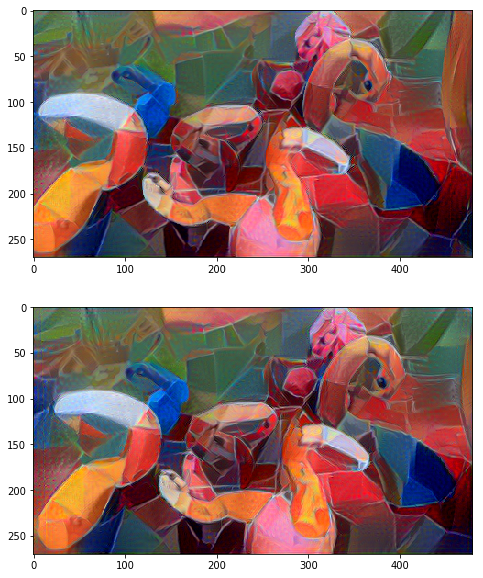

In [16]:
max_iter = 500
show_iter = 100

opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter=1);

n_iter=[0]
s = opt_img_r.size()

while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        loss += sum(layer_losses)
        
        newR = F.grid_sample(opt_img_l, Variable(torch.FloatTensor(grid_scaled), requires_grad=False).cuda())
                    
        loss_disp = (ind_matrix*((opt_img_r-newR))**2).sum() 
        loss += 0.05*loss_disp
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Time: %.1f' % ((time.time()- begin)))
            print('Disparity loss: ', loss_disp.data.cpu().numpy())

        return loss
    
    optimizer.step(closure)
    
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [17]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_truth_134_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_truth_134_l.png')

## Disparity map with deep match

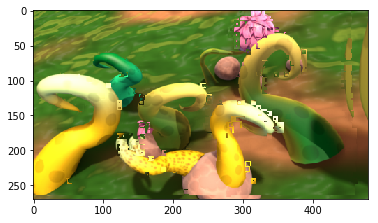

In [18]:
m_v = np.loadtxt('134vertical.txt').astype(int)
m_h = np.loadtxt('134horisontal.txt').astype(int)

new_image = np.zeros_like(imgL)
m, n = m_v.shape

x = np.arange(0, n)
y = np.arange(0, m)
xx, yy = np.meshgrid(x, y)
i, j = np.array(xx, dtype = int), np.array(yy, dtype = int)
opt_img_l = Variable(content_image_l.data.clone(), requires_grad=True)
opt_img_r = Variable(content_image_r.data.clone(), requires_grad=True)
optimizer = optim.LBFGS([opt_img_r, opt_img_l], max_iter = 20)

grid = np.expand_dims(np.stack([i+m_v,j+m_h], axis = 2),0)
grid_scaled = np.zeros_like(grid, dtype=np.float64)
grid_scaled[:,:,:,0] = (-1. + 2.*(grid[:,:,:,0] - grid[:,:,:,0].min())/(grid[:,:,:,0].max() - grid[:,:,:,0].min()))
grid_scaled[:,:,:,1] = (-1. + 2.*(grid[:,:,:,1] - grid[:,:,:,1].min())/(grid[:,:,:,1].max() - grid[:,:,:,1].min()))
grid_scaled = Variable(torch.FloatTensor(grid_scaled), requires_grad=False).cuda()
m_v_var = Variable(torch.from_numpy((m_v>0).astype(np.float32)), requires_grad=False).cuda()
new_image = F.grid_sample(opt_img_l, grid_scaled)
out_img = postp(new_image.data[0].cpu().squeeze())
imshow(out_img)

Iteration: 100, loss: 7062643.500000
('Loss on disp:', 9456292.0)
Time: 0.1
Iteration: 200, loss: 3261866.750000
('Loss on disp:', 1914663.9)
Time: 0.1
Iteration: 300, loss: 2300588.750000
('Loss on disp:', 903083.0)
Time: 0.1
Iteration: 400, loss: 1855469.250000
('Loss on disp:', 508936.22)
Time: 0.1
Iteration: 500, loss: 1647754.375000
('Loss on disp:', 326549.19)
Time: 0.1


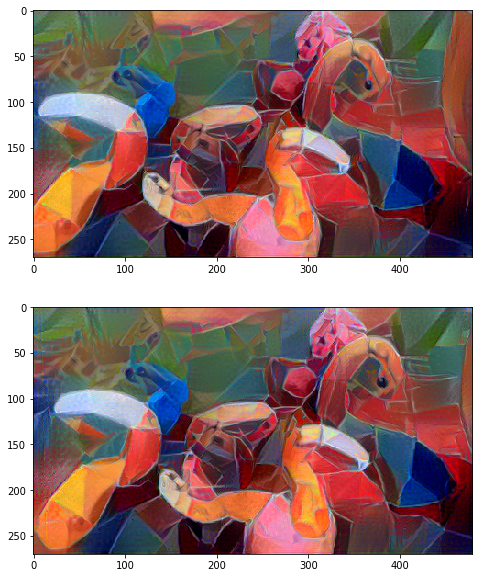

In [19]:
#run style transfer
max_iter = 500 # 500
show_iter = 100 # 50
#optimizer = optim.LBFGS([opt_img_r, opt_img_l]);
n_iter=[0]
s = opt_img_r.size()
while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        new_image = F.grid_sample(opt_img_l, grid_scaled) # for cv2 - right
        

        loss += sum(layer_losses)
        loss_disp = ((m_v_var*(opt_img_r-new_image))**2).sum() # for cv2 - left
        loss += 0.05*loss_disp  
        
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Loss on disp:', loss_disp.data.cpu().numpy()[0])
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [20]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_deep_134_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/final/cube_deep_134_l.png')

Iteration: 100, loss: 6606098.500000
('Loss on disp:', 5154230.0)
Time: 0.1
Iteration: 200, loss: 3005111.500000
('Loss on disp:', 1551839.8)
Time: 0.1
Iteration: 300, loss: 1938821.000000
('Loss on disp:', 535969.19)
Time: 0.1
Iteration: 400, loss: 1522076.875000
('Loss on disp:', 303103.25)
Time: 0.1
Iteration: 500, loss: 1318849.500000
('Loss on disp:', 158846.31)
Time: 0.1


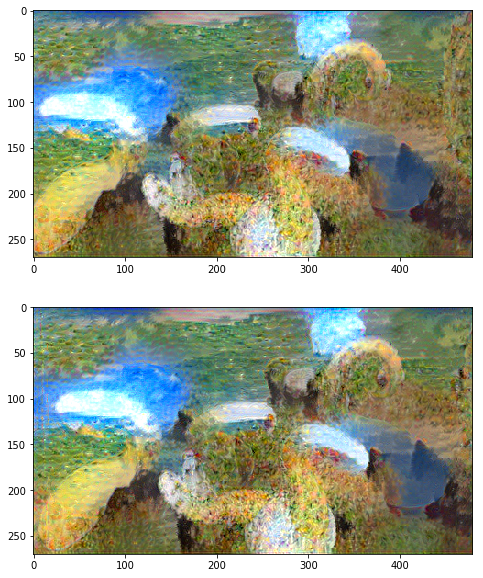

In [200]:
#run style transfer
max_iter = 500 # 500
show_iter = 100 # 50
#optimizer = optim.LBFGS([opt_img_r, opt_img_l]);
n_iter=[0]
s = opt_img_r.size()
while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        new_image = F.grid_sample(opt_img_l, grid_scaled) # for cv2 - right
        

        loss += sum(layer_losses)
        loss_disp = ((m_v_var*(opt_img_r-new_image))**2).sum() # for cv2 - left
        loss += 0.05*loss_disp  
        
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Loss on disp:', loss_disp.data.cpu().numpy()[0])
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

Iteration: 100, loss: 7225960.500000
('Loss on disp:', 9636004.0)
Time: 0.1
Iteration: 200, loss: 3278008.500000
('Loss on disp:', 1947023.6)
Time: 0.1
Iteration: 300, loss: 2316632.500000
('Loss on disp:', 916781.62)
Time: 0.1
Iteration: 400, loss: 1879108.625000
('Loss on disp:', 535826.5)
Time: 0.1
Iteration: 500, loss: 1667507.125000
('Loss on disp:', 339001.59)
Time: 0.1


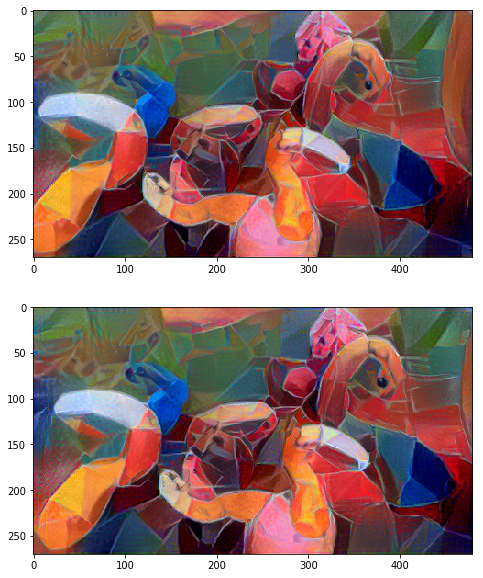

In [103]:
#run style transfer
max_iter = 500 # 500
show_iter = 100 # 50
#optimizer = optim.LBFGS([opt_img_r, opt_img_l]);
n_iter=[0]
s = opt_img_r.size()
while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        new_image = F.grid_sample(opt_img_l, grid_scaled) # for cv2 - right
        

        loss += sum(layer_losses)
        loss_disp = ((m_v_var*(opt_img_r-new_image))**2).sum() # for cv2 - left
        loss += 0.05*loss_disp  
        
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Loss on disp:', loss_disp.data.cpu().numpy()[0])
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [104]:
img_styled = postp(opt_img_r.data[0].cpu().squeeze())
img_styled.save('Images/tentkl_cube_styled_r.png')
img_styled = postp(opt_img_l.data[0].cpu().squeeze())
img_styled.save('Images/tentkl_cube_styled_l.png')

Iteration: 100, loss: 2652997.500000
('Loss on disp:', 17537.867)
Time: 0.1
Iteration: 200, loss: 2491234.000000
('Loss on disp:', 15606.578)
Time: 0.1
Iteration: 300, loss: 2378288.250000
('Loss on disp:', 10067.534)
Time: 0.1
Iteration: 400, loss: 2297340.750000
('Loss on disp:', 7236.3184)
Time: 0.1
Iteration: 500, loss: 2234460.000000
('Loss on disp:', 5960.3174)
Time: 0.1


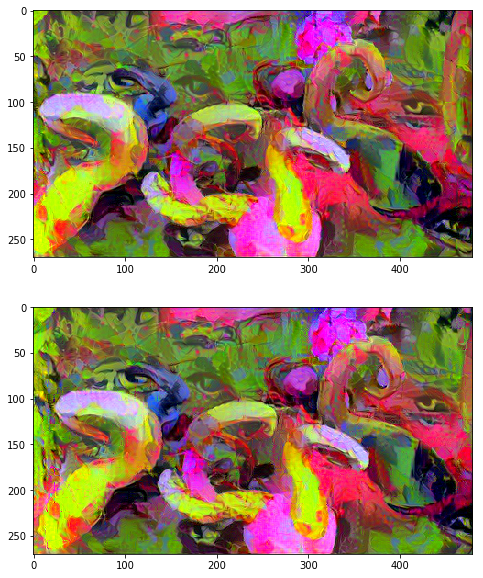

In [34]:
#run style transfer
max_iter = 500 # 500
show_iter = 100 # 50
#optimizer = optim.LBFGS([opt_img_r, opt_img_l]);
n_iter=[0]
s = opt_img_r.size()
while n_iter[0] < max_iter:

    def closure():
        begin = time.time()
        optimizer.zero_grad()
        out_r = vgg(opt_img_r, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_r[a]) for a,A in enumerate(out_r)]
        loss = sum(layer_losses)
        out_l = vgg(opt_img_l, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets_l[a]) for a,A in enumerate(out_l)]
        new_image = F.grid_sample(opt_img_l, grid_scaled) # for cv2 - right
        

        loss += sum(layer_losses)
        #loss_disp = (((new_image[:,:,:,17:] > 0).float()*(opt_img_l[:,:,:,17:]-new_image[:,:,:,17:]))**2).sum()
        #loss_disp = (((opt_img_l[:,:,13:-13,60:-13]-new_image[:,:,13:-13,60:-13]))**2).sum() # to do: add disparity loss 
        loss_disp = ((m_v_var*(opt_img_r-new_image))**2).sum() # for cv2 - left
        loss += 0.5*loss_disp  
        
        loss.backward()
        n_iter[0]+=1

        if (n_iter[0]-1)%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0], loss.data[0]))
            print('Loss on disp:', loss_disp.data.cpu().numpy()[0])
            print('Time: %.1f' % ((time.time()- begin)))
        return loss
    
    optimizer.step(closure)
    
#display result
plt.subplot(211)
out_img = postp(opt_img_r.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
plt.subplot(212)
out_img = postp(opt_img_l.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)